In [1]:
import numpy as np
import scipy
import scipy.integrate as spi
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import torch
import scipy.optimize as spo

/cis/home/yma93/miniconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [228]:
def solve_equation(f, range, tol=1e-5):
    """
    Find the root of the function f in the interval [a, b] using binary search.
    """
    a,b = range
    if f(a) * f(b) > 0:
        print("Possibly no solution in the interval, give best estimate")
        return a if abs(f(a)) < abs(f(b)) else b
    while abs(a-b)>tol:
        midpoint = (a + b) / 2.0
        f_a, f_midpoint = f(a), f(midpoint)
        if abs(f_midpoint) < tol:
            return midpoint
        if f_a * f_midpoint < 0:
            b = midpoint
        else:
            a = midpoint
    return (a+b)/2.0


def gaussian_integral(f):
    """General calculation of E[f(x)] for x ~ N(0, 1)."""
    return spi.quad(
        lambda x: f(x) * np.exp(-(x**2) / 2.0) / np.sqrt(2.0 * np.pi), -np.inf, np.inf
    )[0]

def H(z, sigma):
    """Subordination function."""
    return z + gaussian_integral(lambda x: 1 / (z - sigma(x)))

def H_prime(z, sigma, sigma_image):
    """Subordination function derivative."""
    if z >= sigma_image[0] and z <= sigma_image[1]: # H_prime undefined when z is in the range of the support of nu
        return -np.inf
    return 1.0 - gaussian_integral(lambda x: 1 / (z - sigma(x)) ** 2)

def theta(c, sigma, sigma_image):
    """Compute the effective signal."""
    def f(lam): # lam_max is the root of this function, note it decreases in lam
        return gaussian_integral(lambda x: 1.0 / (lam - sigma(c + x))) - 1.0 / c
    
    a = sigma_image[1] + 1e-7 # lower bound for lam_max
    b = c + max(abs(sigma_image[0]), abs(sigma_image[1])) # upper bound for lam_max
    # print(c,a,b, f(a), f(b))
    if not (f(a)>0 and f(b)<0): # no outlier eigenvalue (all eigenvalues are inside the image of sigma)
        return sigma_image[1] # return something inside the image of sigma, so that H'(theta) is undefined

    # xs = np.linspace(a, b, 100)
    # f_values = np.array([f(lam) for lam in xs])
    # plt.plot(xs, f_values)
    # plt.show()
    # i = np.where(f_values > 0)[0][-1]
    lam_max = solve_equation(f, [a,b]) # find the root by binary search
    return lam_max

def c_critical(c_range, sigma, sigma_image, plot=True):
    """Critical value of c."""
    if plot:  # plot the diagram for theta(c) and H_prime(theta(c)) values
        c_values = np.linspace(c_range[0], c_range[1], 100)
        theta_values = np.array([theta(c, sigma, sigma_image) for c in c_values])
        H_prime_values = np.array([H_prime(theta, sigma, sigma_image) for theta in theta_values])
        # i = np.where(H_prime_values > -1)[0][0] # only plot the part where H_prime > -1
        i=0
        fig, axes = plt.subplots(2, 1, sharex=True)
        axes[0].plot(c_values[i:], theta_values[i:])
        axes[1].plot(c_values[i:], H_prime_values[i:])  
        axes[0].set_xlabel('$c$ (clique size)')
        axes[0].set_ylabel('$\\theta(c)$ (effective signal)')  
        axes[1].set_xlabel('$c$ (clique size)')
        axes[1].set_ylabel('$H^{\\prime}(\\theta(c))$')
        plt.show()

    c_critical = solve_equation(lambda c: H_prime(theta(c, sigma, sigma_image),sigma, sigma_image), c_range)
    return c_critical

def outlier_eval(c, sigma, sigma_image):
    """Evaluate the outlier eigenvalue when c > c_critical."""
    return H(theta(c, sigma, sigma_image), sigma)

# Validation of the method on simple $\sigma = \tanh$ 

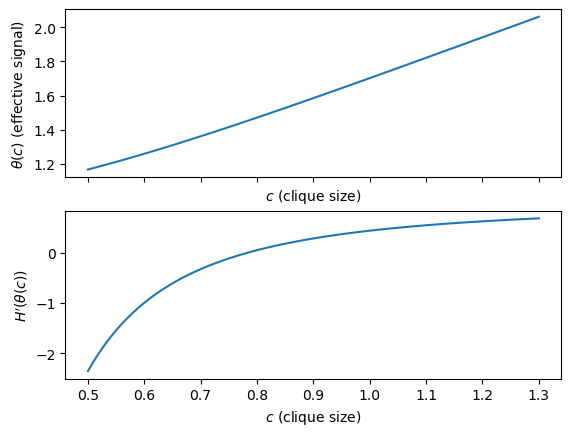

0.7843383789062501

In [229]:
sigma = lambda x:np.tanh(x)
c_critical(c_range=[0.5, 1.3], sigma=sigma, sigma_image=[-1,1], plot=True)

In [22]:
def _plant_clique(G, k):
    n = G.number_of_nodes()
    vertices = np.random.choice(np.arange(n), k, replace=False)
    for index, u in enumerate(vertices):
        for v in vertices[index + 1 :]:
            G.add_edge(u, v)
    return G

def custom_laplacian_lam_max(A, sigma):
    """Given adjacency matrix A, compute lambda_max(L) where L = \hat{A} + diag(sigma(\hat{d}))"""
    A = torch.Tensor(A).squeeze()
    n = A.shape[-1]
    A_normalized = (A * 2 - torch.ones(n,n) + torch.eye(n))/ np.sqrt(n)
    D = sigma(A_normalized.sum(axis=1))
    evals = torch.linalg.eigvalsh(A_normalized + torch.diag_embed(D))
    return evals.max().item()

def find_lam_max(sigma, n_range=np.arange(2000, 3000,500), c=0.8, num_trials = 50):
    er = {}
    planted = {}
    for n in tqdm(n_range):
        k = int(c*np.sqrt(n))
        er_n = []
        planted_n = []
        for trials in tqdm(range(num_trials)):
            # generate a random ER graph
            G = nx.erdos_renyi_graph(n, p=.5)
            A = nx.adjacency_matrix(G).toarray()
            er_n.append(custom_laplacian_lam_max(A, sigma))
            # generate a random planted graph
            G = nx.erdos_renyi_graph(n, p=.5)
            G = _plant_clique(G, k)
            A = nx.adjacency_matrix(G).toarray()    
            planted_n.append(custom_laplacian_lam_max(A, sigma))
        er[n] = er_n
        planted[n] = planted_n
    return er, planted


def find_lam_max(sigma, n, c, num_trials=100):
    er = {}
    planted = {}
    k = int(c * np.sqrt(n))
    er_n = []
    planted_n = []
    for trials in tqdm(range(num_trials)):
        # generate a random ER graph
        G = nx.erdos_renyi_graph(n, p=0.5)
        A = nx.adjacency_matrix(G).toarray()
        er_n.append(custom_laplacian_lam_max(A, sigma))
        # generate a random planted graph
        G = nx.erdos_renyi_graph(n, p=0.5)
        G = _plant_clique(G, k)
        A = nx.adjacency_matrix(G).toarray()
        planted_n.append(custom_laplacian_lam_max(A, sigma))
    er[n] = er_n
    planted[n] = planted_n
    return er, planted


def layer_plot(
        ax,
        xs,
        yss,
        max_points=None,
        label=None,
        only_means=False,
        errorbars=False,
        color=None,
        sigma=1.0,
        fill_alpha=0.3,
        linestyle='-',
        linewidth=1,
        elinewidth=1):
    means = np.array([np.mean(ys) for ys in yss])
    devs = np.array([np.std(ys) * sigma for ys in yss])
    print(means)
    if max_points is not None:
        n = xs.shape[0]
        thin = max(1, n // max_points)
        xs = xs[::thin]
        means = means[::thin]
        devs = devs[::thin]
    if errorbars:
        ax.scatter(xs, means, c=color, label=label)
        ax.errorbar(xs, means, yerr=devs, linestyle=linestyle, linewidth=linewidth, elinewidth=elinewidth, c=color)
    else:
        ax.plot(xs, means, c=color, label=label, linestyle=linestyle, linewidth=linewidth)
        if not only_means:
            ax.fill_between(xs, means, means + devs, alpha=fill_alpha, color=color)
            ax.fill_between(xs, means, means - devs, alpha=fill_alpha, color=color)

def plot_lam_max(er, planted, n_range):
    er = [er[n] for n in n_range]
    planted = [planted[n] for n in n_range]
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    layer_plot(ax, n_range, er, label='ER', errorbars=False, color = "blue")
    layer_plot(ax, n_range, planted, label='Planted', errorbars=False, color = "orange")
    ax.set_xlabel('n')
    ax.set_ylabel('Maximum Eigenvalue')
    ax.legend()
    plt.show()

In [23]:
# c=0.8
outlier_eval(0.8, sigma, sigma_image=[-1,1])

2.331392707303668

In [8]:
er, planted = find_lam_max(sigma, n_range=np.arange(2000, 3500,500), c=0.8)

100%|██████████| 3/3 [25:54<00:00, 518.01s/it]


[2.3189535 2.3237648 2.3253834]
[2.3374226 2.3370156 2.3367243]


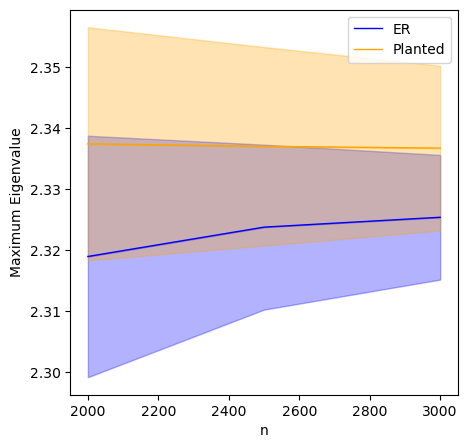

In [10]:
plot_lam_max(er, planted, np.arange(2000, 3500,500))

In [20]:
# c=1
outlier_eval(1.0, sigma, sigma_image=[-1,1])

2.393604676317687

100%|██████████| 3/3 [26:12<00:00, 524.23s/it]

[2.320394  2.328399  2.3249865]
[2.3778467 2.385728  2.3821602]


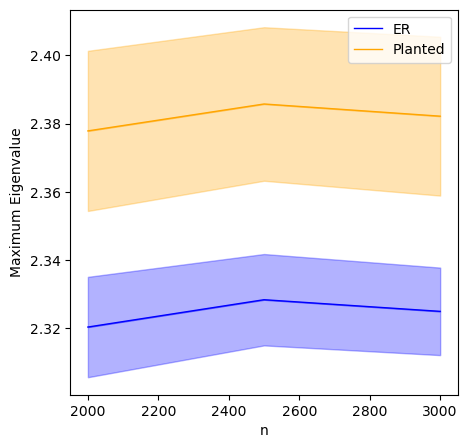

In [12]:
er, planted = find_lam_max(sigma, n_range=np.arange(2000, 3500, 500), c=1)
plot_lam_max(er, planted, np.arange(2000, 3500, 500))

# Validation of the method on learned model

In [24]:
import wandb
import shutil,os
import pytorch_lightning as pl
import torch.nn as nn
import torch
from train import GNNTrainingModule

CURRENT_DIR = os.getcwd()
ENTITY_NAME = "yuxinma"
PROJECT_NAME = "planted_clique_v2"

ptwise_degree_model = ["m2e9wwl6", "ng6lo20c", "ifugj2bs", "c706gw3o", "b8nvdxoc"]
ptwise_degree_model2 = ["lghepjzi", "x03ktnj8", "wgn96mpy", "okvs07ur"]

def download_best_model(run_id: str) -> pl.LightningModule:
    """ Download from wandb logs the model checkpoint and its config"""
    #download the best model checkpoint
    api = wandb.Api()
    artifact = api.artifact(f"{ENTITY_NAME}/{PROJECT_NAME}/model-{run_id}:best")  #download the best_model
    best_ckpt = artifact.download(root = os.path.join(CURRENT_DIR, "downloaded_artifact"))
    best_ckpt = os.path.join(best_ckpt, "model.ckpt")
    best_model = GNNTrainingModule.load_from_checkpoint(best_ckpt, map_location=None)

    #get the run config
    run = api.run(f"{ENTITY_NAME}/{PROJECT_NAME}/{run_id}")
    config = run.config

    #clean up
    shutil.rmtree(os.path.dirname(best_ckpt))
    return best_model, config

def asymptotic_analysis(model,n,c):
    """Plot histogram of eigenvalues of X and L for a planted clique graph.
    """
    model.eval()
    model.to('cpu')
    k = int(c*np.sqrt(n))
    G = nx.erdos_renyi_graph(n, p=.5)
    A0 = nx.adjacency_matrix(G).toarray()
    A0 = torch.Tensor(A0).unsqueeze(0)
    A0 = (A0 * 2 - torch.ones(n, n) + torch.eye(n)) / np.sqrt(n)
        
    G = _plant_clique(G, k)
    A = nx.adjacency_matrix(G).toarray()
    A = torch.Tensor(A).unsqueeze(0)
    A, x, pred = model(A)
    A = A.squeeze(0).squeeze(0)
    
    X = A- A0
    D = torch.linalg.eigvalsh(X).squeeze().detach().numpy()
    plt.figure(figsize=(10, 5))
    plt.hist(D, bins=200)
    plt.title(r"Eigenvalue Histogram of $X=c\hat 1_S \hat 1_S^{\top} + diag(\sigma(c1_S + d))$")
    plt.show()

    D = torch.linalg.eigvalsh(A).squeeze().detach().numpy()
    print(D.max())
    plt.figure(figsize=(10, 5))
    plt.hist(D, bins=200)
    plt.title(r"Eigenvalue Histogram of $L = \frac{W}{\sqrt{n}} + X$")
    plt.show()

wandb:   1 of 1 files downloaded.  


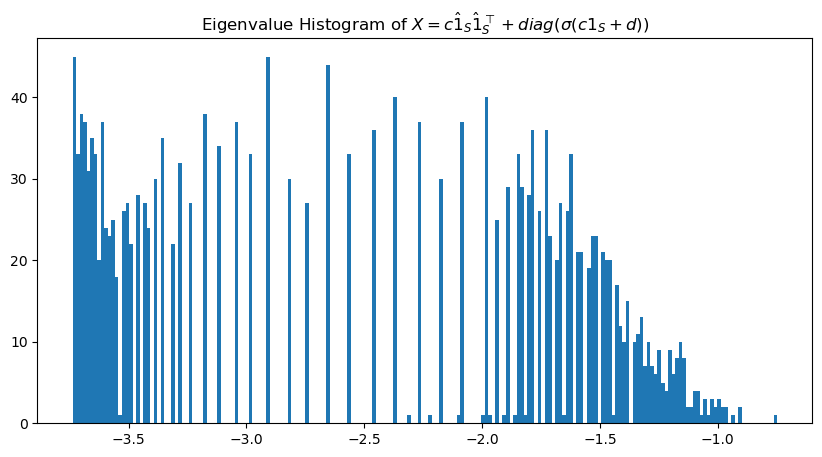

0.07141857


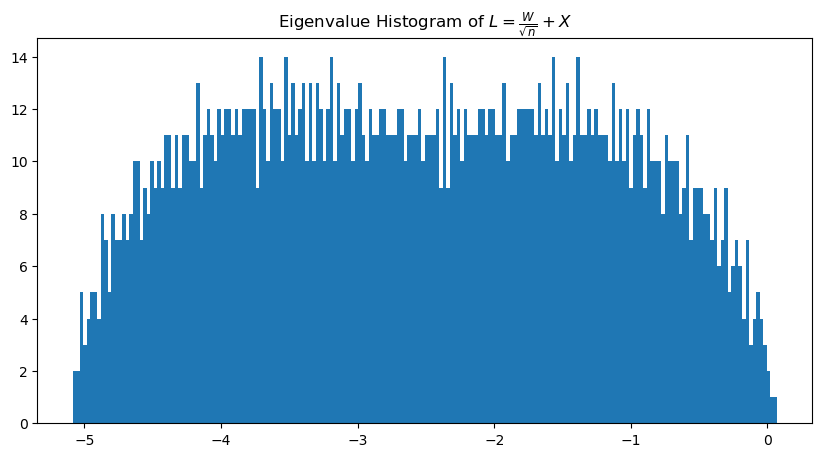

In [25]:
model,config = download_best_model(ptwise_degree_model[0])
asymptotic_analysis(model,2000,.8)

/tmp/ipykernel_3696220/1009986017.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x = torch.range(-10, 10, 0.1).unsqueeze(1)


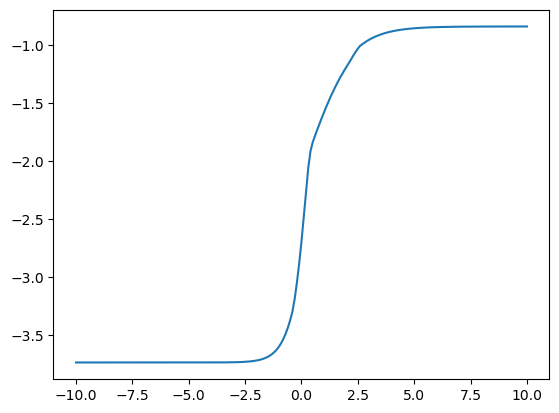

In [26]:
x = torch.range(-10, 10, 0.1).unsqueeze(1)
y = model.model.mlp1(x)
y = nn.Tanh()(y)
y = model.model.mlp2(y) 
plt.plot(x.detach().cpu().numpy(), y.detach().cpu().numpy())


In [29]:
def learned_model(x):
    if isinstance(x, (int, float)):
        x_tensor = torch.tensor(x).reshape(1,1).float()
    if isinstance(x, torch.Tensor) and x.dim() == 1:
        x_tensor = x.reshape(-1,1).float()
    y = model.model.mlp1(x_tensor)
    y = nn.Tanh()(y)
    y = model.model.mlp2(y)
    if isinstance(x, torch.Tensor):
        return y.squeeze()
    if isinstance(x, (int, float)):
        return y.item()

test_xs = torch.linspace(-100, 100, 1000)
image = [learned_model(test_xs).min().item(), learned_model(test_xs).max().item()]
print(f"image of learned model: {image}")

image of learned model: [-3.73762583732605, -0.8382097482681274]


/tmp/ipykernel_3696220/1196932930.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_3696220/1196932930.py:23: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


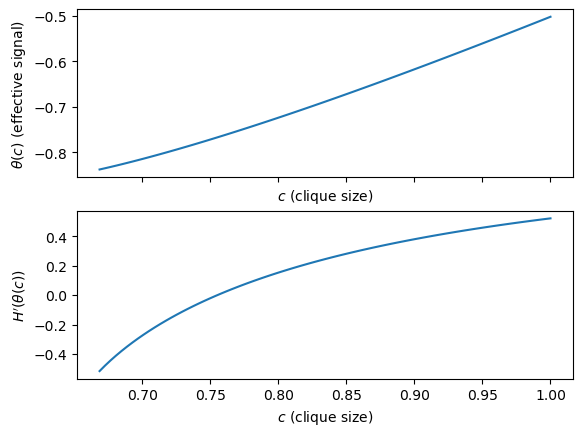

c_critical for m2e9wwl6 = 0.7553009033203124


In [31]:
print(f"c_critical for {ptwise_degree_model[0]} = {c_critical([0.6, 1.0], learned_model, image)}")

In [32]:
outlier_eval(0.75, sigma)

TypeError: outlier_eval() missing 1 required positional argument: 'sigma_image'

In [ ]:
# c=0.8
outlier_eval(0.8, sigma)

/tmp/ipykernel_2614584/3198752794.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_2614584/3198752794.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


0.0213268047502978

In [20]:
er, planted = find_lam_max(sigma, n_range=np.arange(2000, 3500, 500), c=0.8, num_trials=100)

100%|██████████| 3/3 [49:13<00:00, 984.60s/it] 


[0.01312651 0.01651728 0.01949613]
[0.03263712 0.03529229 0.03509303]


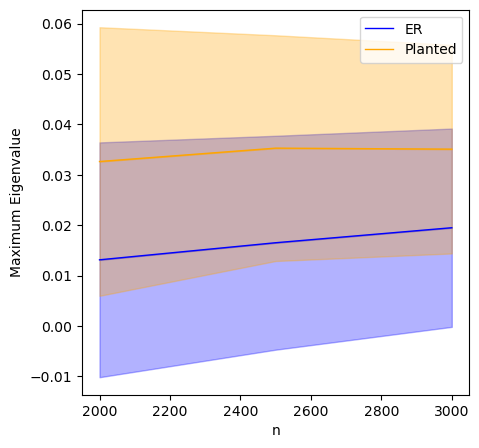

In [21]:
plot_lam_max(er, planted, np.arange(2000, 3500, 500))

In [16]:
outlier_eval(2, sigma)

/tmp/ipykernel_2651913/3198752794.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_2651913/3198752794.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


1.0957327934558707

In [17]:
er, planted = find_lam_max(sigma, n_range=np.arange(2000, 3500, 500), c=2, num_trials=100)

100%|██████████| 3/3 [50:28<00:00, 1009.51s/it]


[0.01697059 0.01627697 0.01600619]
[1.05577498 1.07123472 1.05623381]


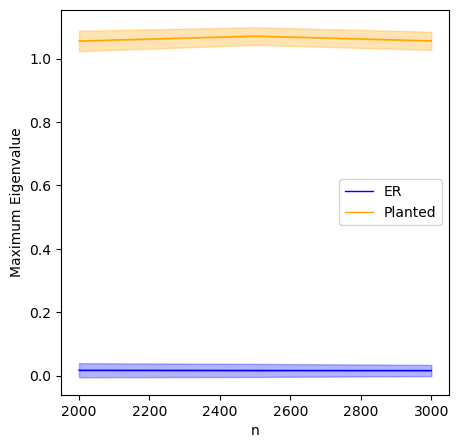

In [19]:
plot_lam_max(er, planted, np.arange(2000, 3500, 500))

In [22]:
outlier_eval(5, sigma)

/tmp/ipykernel_2651913/3198752794.py:34: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_2651913/3198752794.py:34: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return spi.quad(


4.2875760287929285

In [23]:
er, planted = find_lam_max(sigma, n_range=np.arange(2000, 3500, 500), c=5, num_trials=100)

100%|██████████| 3/3 [49:23<00:00, 987.96s/it] 


[0.01664153 0.01497738 0.02036876]
[4.23594371 4.25433989 4.24211484]


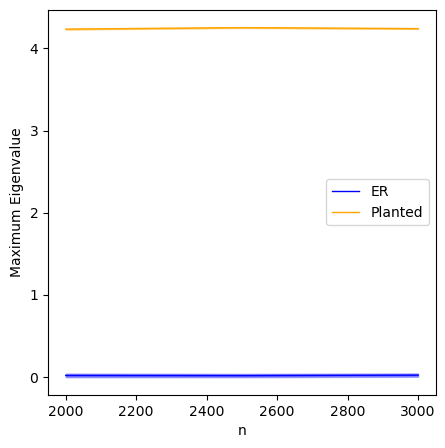

In [24]:
plot_lam_max(er, planted, np.arange(2000, 3500, 500))

# Find Optimal $\sigma$

## $\sigma = a\tanh(bx)$

In [219]:
def c_for_parametrized_tanh(beta):
    """Given parameter for the parametrized sigma function, compute c_critical."""
    sigma = lambda x: beta[0] * np.tanh(beta[1] * x)
    sigma_image = [-beta[0], beta[0]]
    c = c_critical([0.3, 0.9], sigma=sigma, sigma_image = sigma_image, plot=False)
    print(f"beta={beta}, c_critical={c}")
    return c

In [220]:
# check for one evaluation
c_for_parametrized_tanh([1, 1])

IndexError: tuple index out of range

In [36]:
res = spo.minimize(c_for_parametrized_tanh, [1.0, 1.0], method="Nelder-Mead")
print(res.x)

beta=[1. 1.], c_critical=0.7843414306640625
beta=[1.05 1.  ], c_critical=0.7817733764648436
beta=[1.   1.05], c_critical=0.78544921875
beta=[1.05 0.95], c_critical=0.7806152343749999
beta=[1.075 0.9  ], c_critical=0.7782531738281249
beta=[1.125 0.9  ], c_critical=0.7759048461914062
beta=[1.1875 0.85  ], c_critical=0.7720458984375
beta=[1.2125 0.75  ], c_critical=0.7687774658203126
beta=[1.29375 0.625  ], c_critical=0.7635635375976562
beta=[1.40625 0.575  ], c_critical=0.7592651367187501
beta=[1.571875 0.4125  ], c_critical=0.8300582885742187
beta=[1.5125 0.35  ], c_critical=0.8930557250976561
beta=[1.26875 0.725  ], c_critical=0.7660537719726561
beta=[1.43125 0.475  ], c_critical=0.759228515625
beta=[1.5125 0.35  ], c_critical=0.8930557250976561
beta=[1.54375 0.425  ], c_critical=0.8036911010742187
beta=[1.35625 0.575  ], c_critical=0.760894775390625
beta=[1.48125 0.475  ], c_critical=0.7579559326171876
beta=[1.54375 0.425  ], c_critical=0.8036911010742187
beta=[1.50625 0.375  ], c_cri

KeyboardInterrupt: 

## $\sigma$ monotone increasing splines

In [201]:
from scipy.interpolate import CubicSpline

def c_for_cubic_spline(beta):
    """
    Given parameter for the parametrized sigma function, compute c_critical.
    The parametrization is as follows:
    Define sigma to be cubic spline interpolation of the knots inside [0, beta[0]]; constant outside of it with value at the left/right end point.
    The n knots x1, ..., x_n are evenly spaced between [0, beta[0]].
    y_1 = beta[1], y_2 = beta[1]+beta[2], ..., y_n = beta[1] + ... + beta[n] are the values at the knots.
    """
    n = 5
    assert beta[1] > 0
    assert len(beta) == n + 1
    assert (beta[2:] >= 0).all()

    def spline_extrapolate(t):  # extrapolate the spline outside of [a, b] with constant values
        a, b = beta[0], beta[1]
        x = np.linspace(a, b, n)  # knots
        y = np.cumsum(beta[2:])  # values at knots
        y = np.concatenate([[0], y])
        spline = CubicSpline(x, y, bc_type="clamped", extrapolate=False)

        if isinstance(t, (int, float)):
            if t < a:
                return y[0]
            if t > b:
                return y[-1]
            return spline(t)
        elif isinstance(t, torch.Tensor):
            y = torch.tensor(spline(t))
            y[t < a] = spline(a).item()
            y[t > b] = spline(b).item()
            return y

    x = torch.linspace(-10, 10, 100)
    y = spline_extrapolate(x)
    plt.plot(x,y)
    plt.show()
    image = [0, np.sum(beta[2:])]
    c = c_critical([0.3, 0.9], sigma=spline_extrapolate, sigma_image=image, plot=False)
    print(f"beta={beta}, c_critical={c}")
    return c

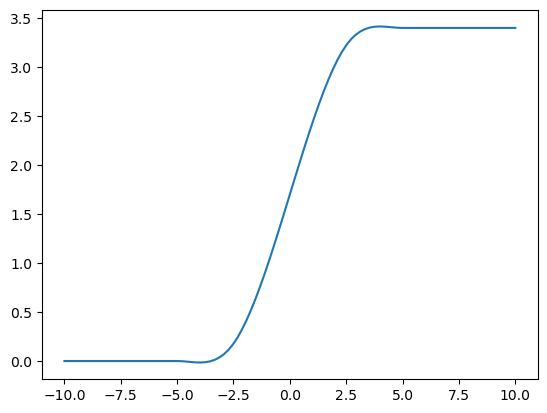

/tmp/ipykernel_3705196/378606294.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(


3.4000000999999997 3.6999999999999997 10.530622728189087 -2.655535539553619


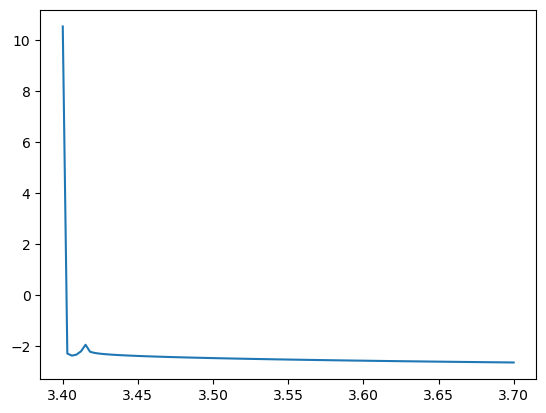

/tmp/ipykernel_3705196/378606294.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return spi.quad(


3.4000000999999997 4.3 207.2917047265751 -0.5550095786220473


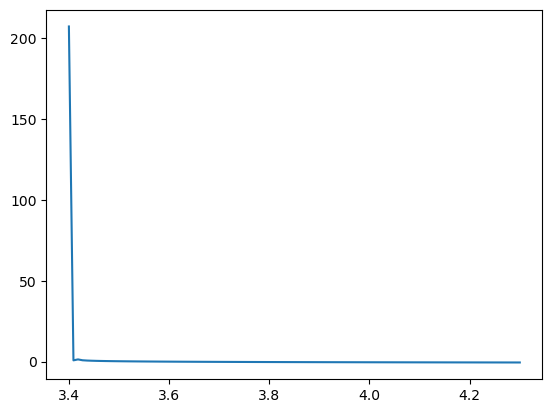

3.4000000999999997 3.6999999999999997 10.530622728189087 -2.655535539553619


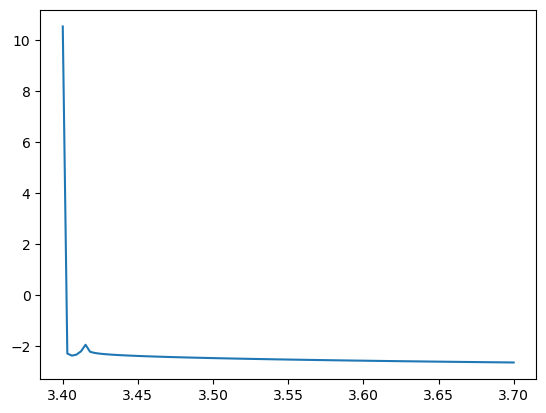

3.4000000999999997 4.0 53.6922480862056 -1.057378236997928


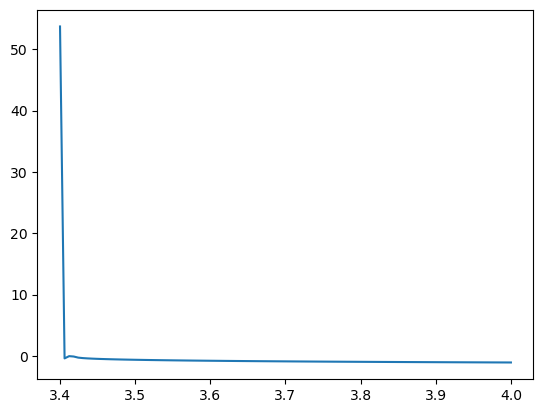

3.4000000999999997 4.0 53.6922480862056 -1.057378236997928


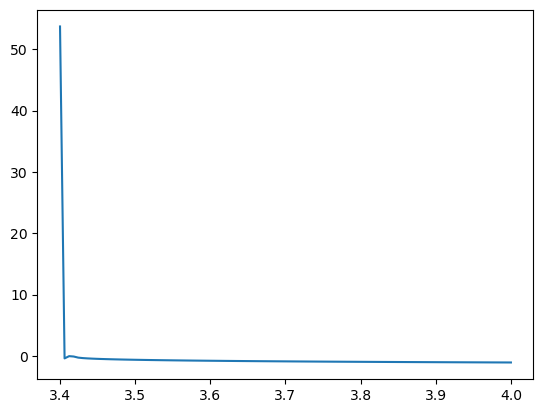

3.4000000999999997 4.15 106.60660986798992 -0.7519087317797156


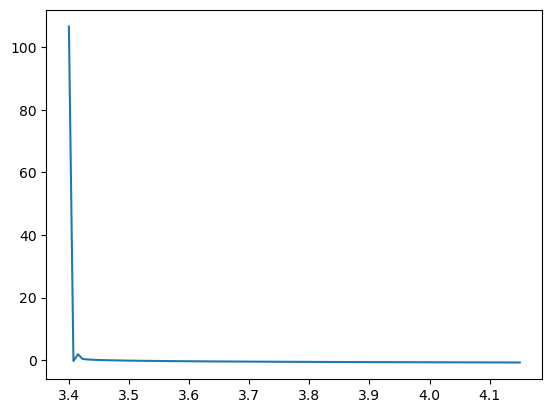

3.4000000999999997 4.15 106.60660986798992 -0.7519087317797156


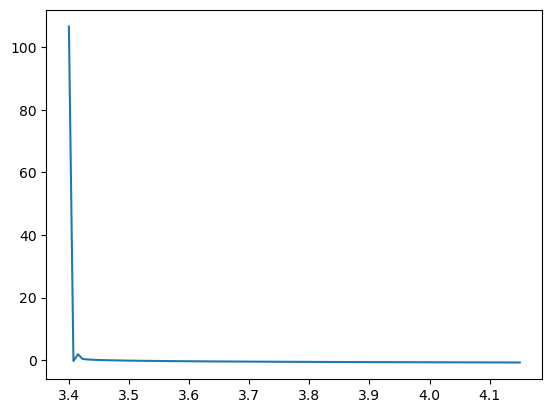

3.4000000999999997 4.225 146.03976094910158 -0.6436309128010826


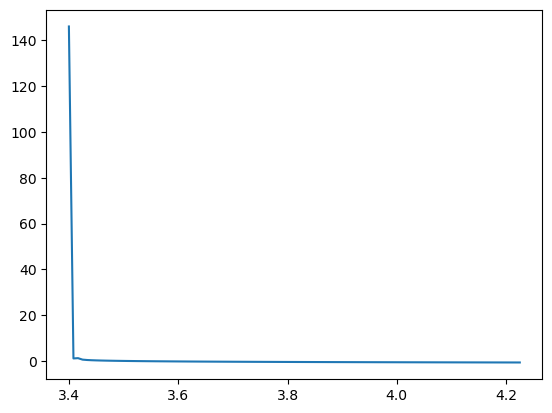

3.4000000999999997 4.15 106.60660986798992 -0.7519087317797156


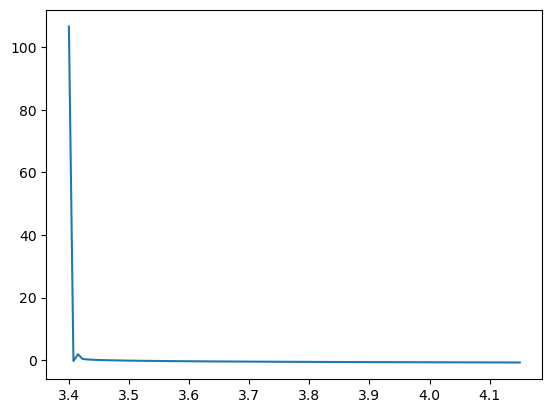

3.4000000999999997 4.1875 125.51820022567652 -0.6949567602903942


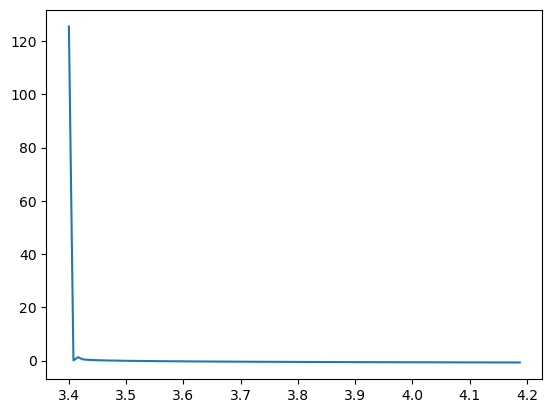

3.4000000999999997 4.15 106.60660986798992 -0.7519087317797156


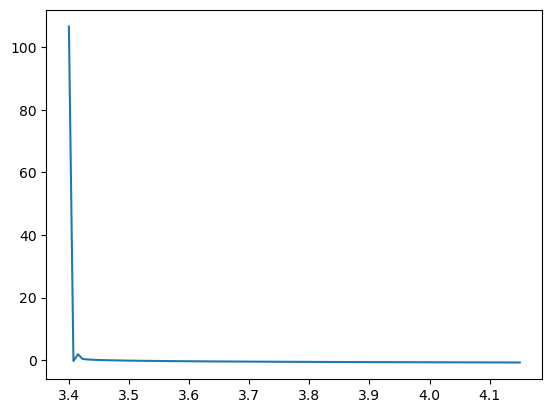

3.4000000999999997 4.16875 116.19905093431073 -0.7226773444440856


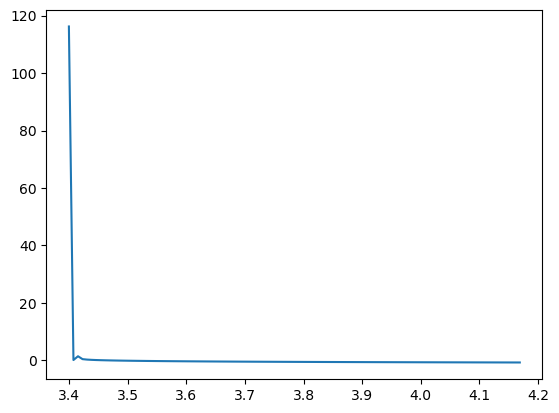

3.4000000999999997 4.15 106.60660986798992 -0.7519087317797156


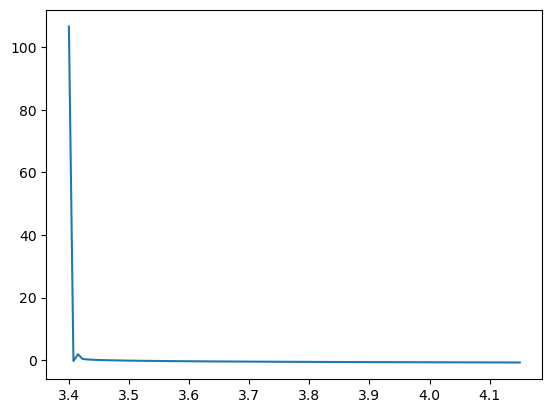

3.4000000999999997 4.159375 111.94619813806219 -0.737097105034068


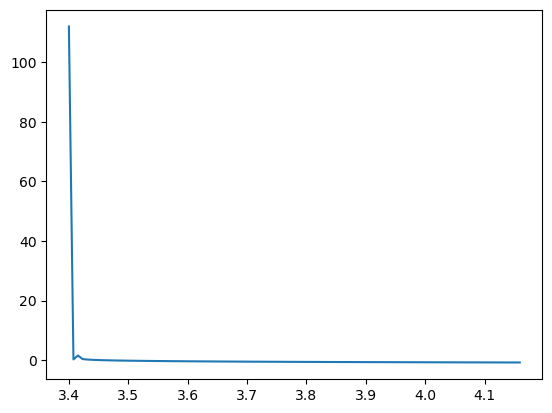

3.4000000999999997 4.159375 111.94619813806219 -0.737097105034068


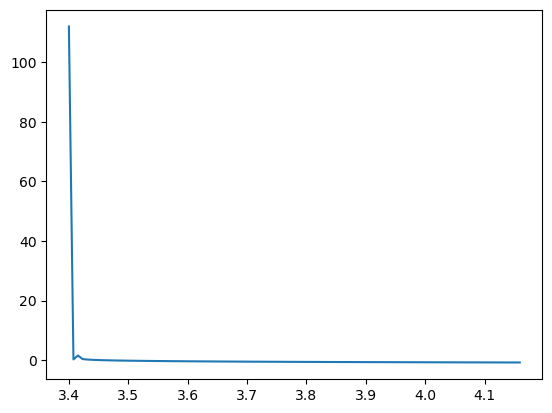

3.4000000999999997 4.1640625 111.60950287929298 -0.7298391540784213


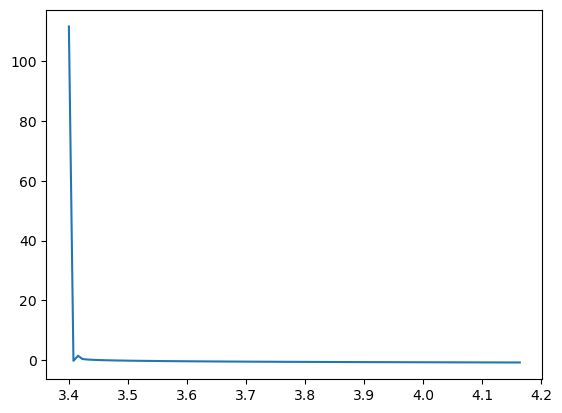

3.4000000999999997 4.1640625 111.60950287929298 -0.7298391540784213


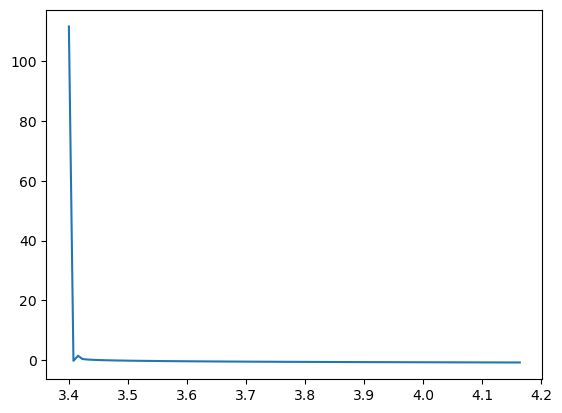

3.4000000999999997 4.16640625 114.34537715951514 -0.7262463432185925


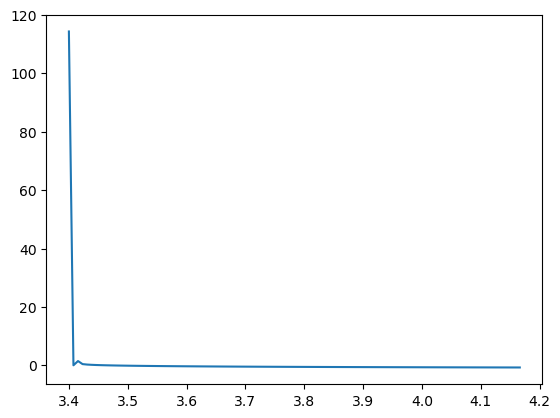

3.4000000999999997 4.16640625 114.34537715951514 -0.7262463432185925


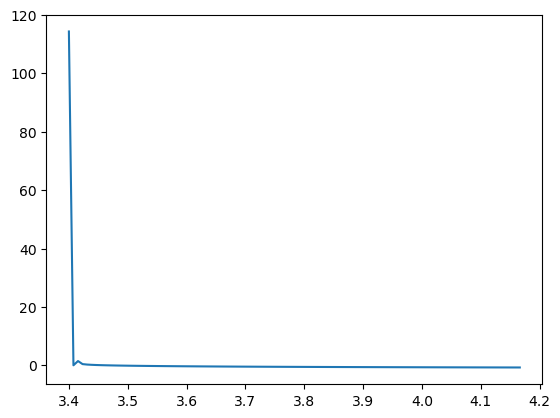

3.4000000999999997 4.167578125 116.62756323302544 -0.7244588811236572


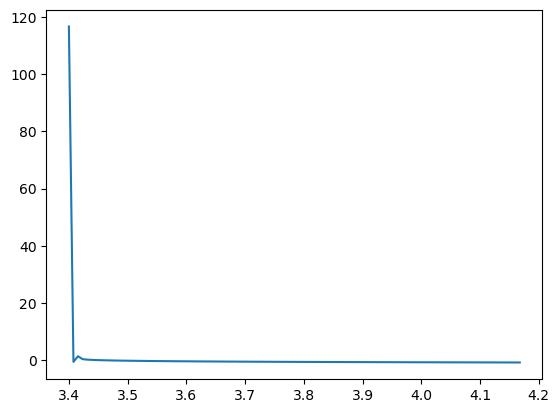

3.4000000999999997 4.167578125 116.62756323302544 -0.7244588811236572


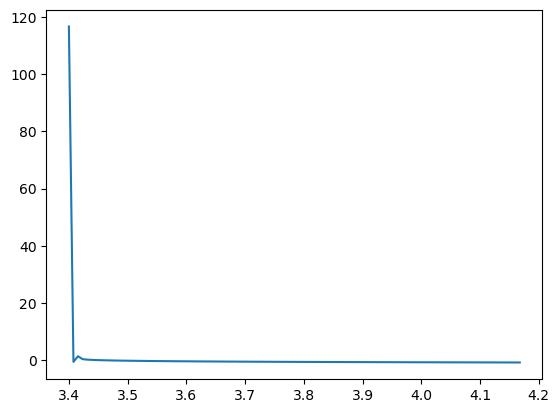

3.4000000999999997 4.1681640625 118.53366172811718 -0.7235673738230665


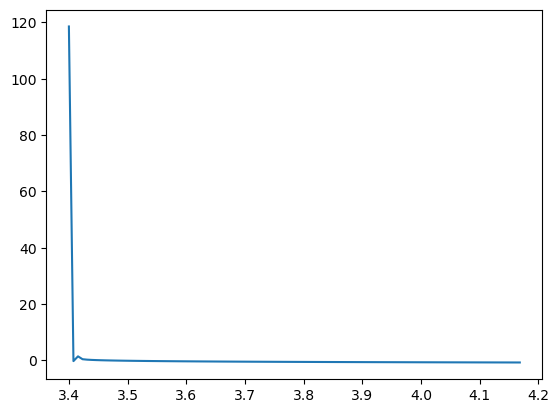

3.4000000999999997 4.1681640625 118.53366172811718 -0.7235673738230665


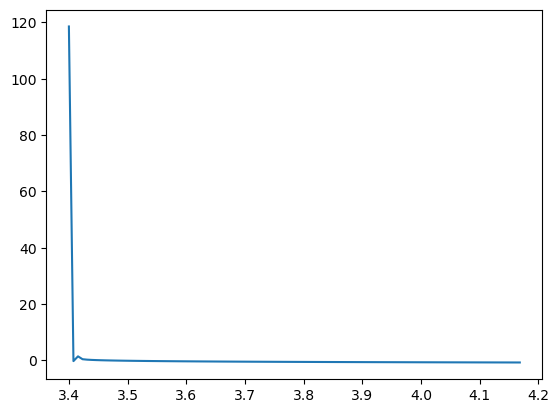

3.4000000999999997 4.16845703125 114.74520749862566 -0.7231221746073139


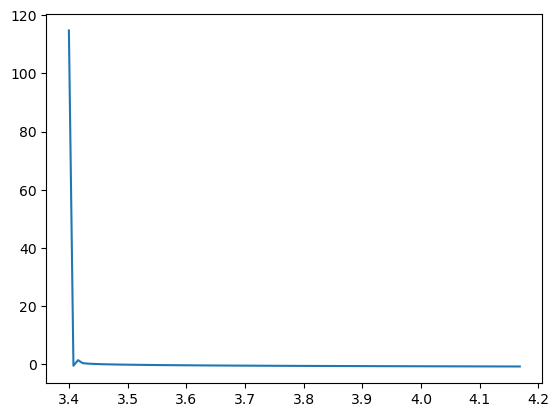

3.4000000999999997 4.1681640625 118.53366172811718 -0.7235673738230665


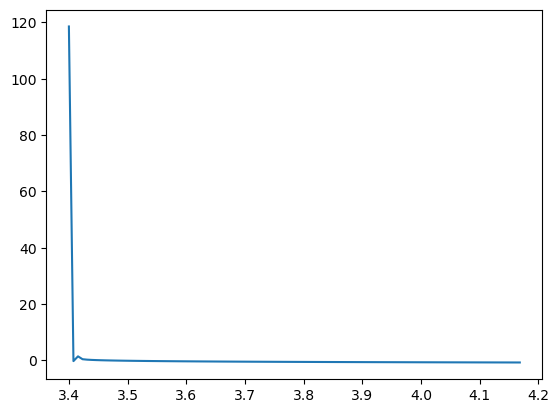

3.4000000999999997 4.168310546875 114.45451604441259 -0.7233447280569083


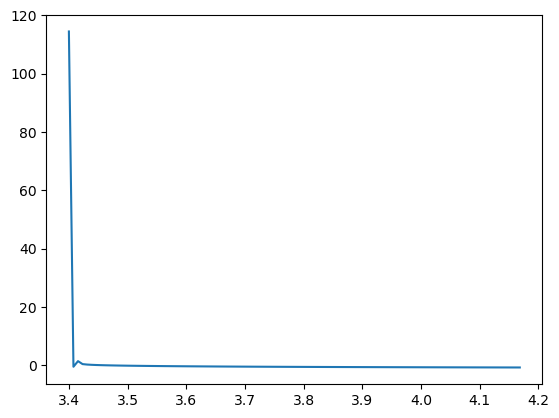

3.4000000999999997 4.168310546875 114.45451604441259 -0.7233447280569083


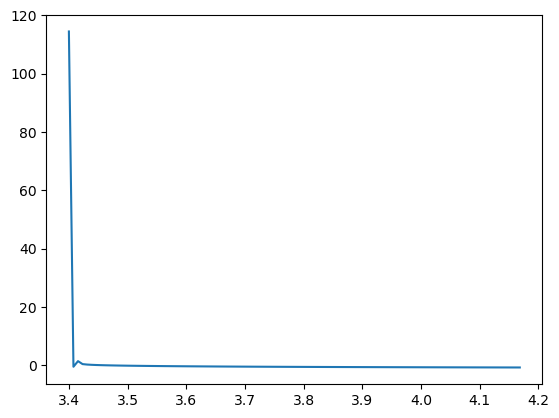

3.4000000999999997 4.1683837890625 117.19303165201474 -0.7232334397958818


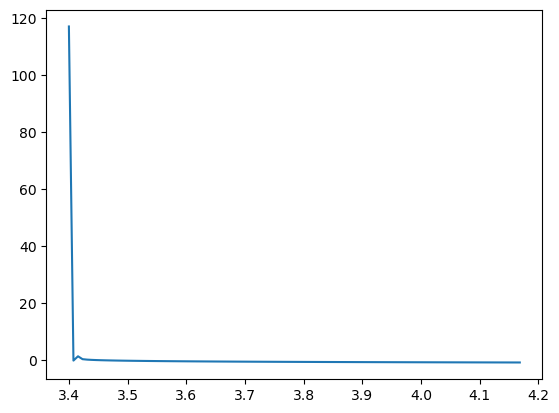

3.4000000999999997 4.1683837890625 117.19303165201474 -0.7232334397958818


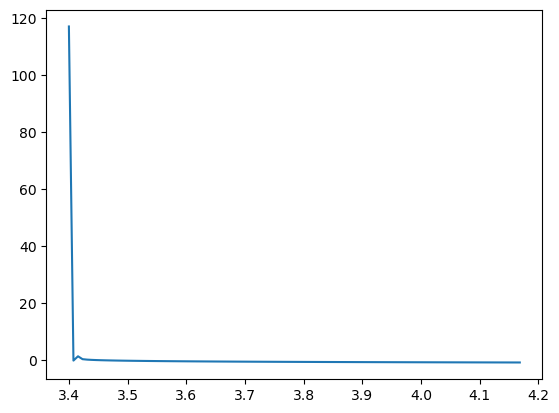

3.4000000999999997 4.16842041015625 114.72703505770716 -0.7231778043179579


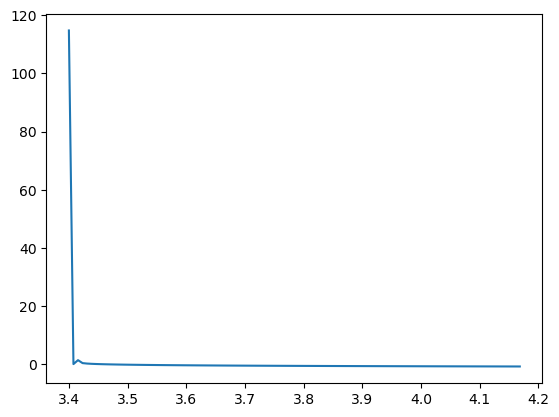

3.4000000999999997 4.1683837890625 117.19303165201474 -0.7232334397958818


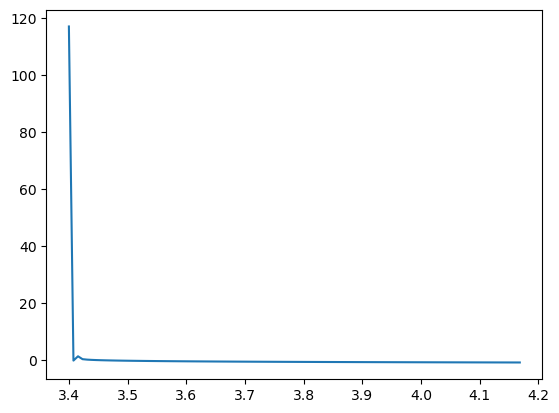

3.4000000999999997 4.168402099609375 114.5988925795611 -0.7232056213359579


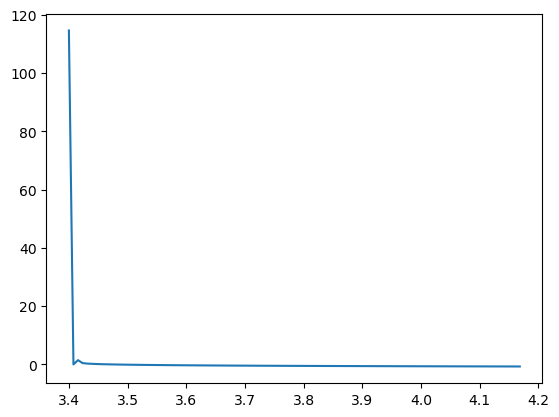

3.4000000999999997 4.1683837890625 117.19303165201474 -0.7232334397958818


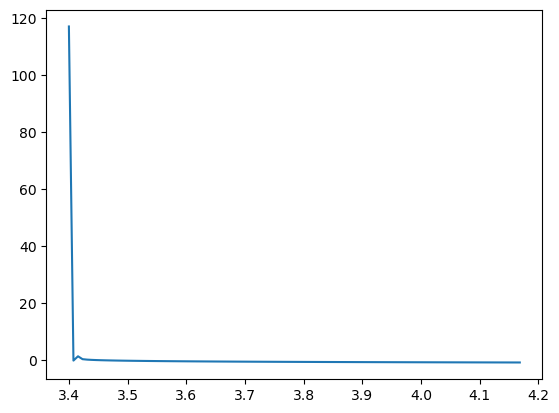

3.4000000999999997 4.168392944335937 114.89373200322727 -0.7232195303856727


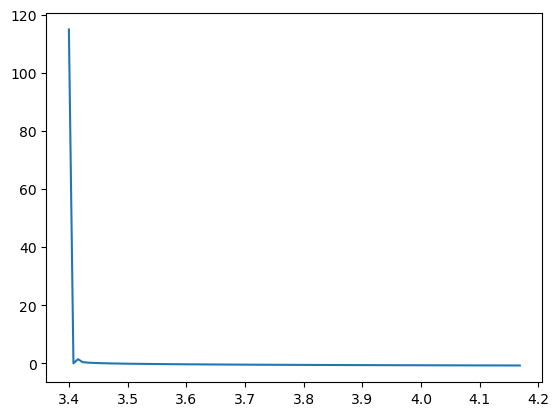

beta=[-5.          5.          0.17732211  1.52267789  1.52267789  0.17732211], c_critical=0.7683975219726562


0.7683975219726562

In [202]:
# define the initial set-up according to the best solution found in tanh case
n = 5
x = np.linspace(-5, 5, n)
y = 1.7 * np.tanh(0.58 * x) + 1.7
y[0], y[-1] = 0, 3.4
delta = y[1:] - y[:-1]
beta0 = np.concatenate(([-5,5], delta))
# define the bounds for the parameters in optimization
bounds = [(None,None), (0, None)] + [(0, None) for _ in range(n-1)]
# check for one evaluation
c_for_cubic_spline(beta=beta0)

In [107]:
spo.minimize(c_for_cubic_spline, beta0, method="Nelder-Mead", bounds=bounds)

/tmp/ipykernel_3705196/196088127.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return spi.quad(
/tmp/ipykernel_3705196/196088127.py:23: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return spi.quad(


beta=[-5.          5.          0.17732211  1.52267789  1.52267789  0.17732211], c_critical=0.7683975219726562
beta=[-5.25        5.          0.17732211  1.52267789  1.52267789  0.17732211], c_critical=0.7624557495117188
beta=[-5.          5.25        0.17732211  1.52267789  1.52267789  0.17732211], c_critical=0.7873031616210937
beta=[-5.          5.          0.18618822  1.52267789  1.52267789  0.17732211], c_critical=0.7684432983398439
beta=[-5.          5.          0.17732211  1.59881178  1.52267789  0.17732211], c_critical=0.7673355102539063
beta=[-5.          5.          0.17732211  1.52267789  1.59881178  0.17732211], c_critical=0.7739089965820314
beta=[-5.          5.          0.17732211  1.52267789  1.52267789  0.18618822], c_critical=0.7692855834960939
Possibly no solution in the interval, give best estimate
beta=[-5.08333333  4.75        0.18027748  1.54805585  1.54805585  0.18027748], c_critical=0.9
beta=[-5.02083333  5.125       0.17806096  1.52902238  1.52902238  0.17806096]

/tmp/ipykernel_3705196/196088127.py:23: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return spi.quad(


beta=[-5.31351809  4.98107425  0.17585013  1.53050733  1.48387227  0.1809298 ], c_critical=0.7597640991210939
beta=[-5.28574835  4.87065436  0.18091513  1.60470507  1.37153741  0.17809861], c_critical=0.7575164794921876
beta=[-5.47692598  4.8551401   0.17494074  1.60116458  1.43524142  0.17363298], c_critical=0.7576171875000001
beta=[-5.2448262   4.78550573  0.17662343  1.5871842   1.47096378  0.18032834], c_critical=0.7573699951171875
beta=[-5.27452307  4.8421798   0.17718867  1.57971835  1.50821961  0.17348541], c_critical=0.7580749511718752
beta=[-5.32873397  4.871087    0.17813278  1.59024201  1.40082129  0.17977011], c_critical=0.7574615478515626
beta=[-5.36053495  4.82807969  0.17464377  1.56052078  1.40769687  0.17796864], c_critical=0.7576126098632814
beta=[-5.12258975  4.85280833  0.17988152  1.55307936  1.41263771  0.18375974], c_critical=0.7579605102539064
beta=[-5.38834192  4.85455716  0.17617593  1.58914328  1.42959049  0.17616467], c_critical=0.7574340820312501
beta=[-5.2

/tmp/ipykernel_3705196/196088127.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  return gaussian_integral(lambda x: 1.0 / (lam - sigma(c + x))) - 1.0 / c


beta=[-5.20860592  4.91581327  0.17288092  1.5869997   1.46706935  0.17782677], c_critical=0.7587478637695313
beta=[-5.2095586   4.9165743   0.17291565  1.58647052  1.46679273  0.17780545], c_critical=0.7587432861328125
beta=[-5.21039214  4.91628431  0.17298313  1.58554419  1.4670577   0.17780936], c_critical=0.75875244140625
beta=[-5.20905247  4.91593103  0.17290647  1.58663582  1.46706643  0.17782241], c_critical=0.7587478637695313
beta=[-5.20894724  4.91624806  0.17293019  1.58622755  1.46719194  0.17781836], c_critical=0.7587570190429687
beta=[-5.20924825  4.91618985  0.17291185  1.58618459  1.46741944  0.17781175], c_critical=0.7587570190429687
beta=[-5.20908793  4.91624454  0.17291933  1.5861771   1.46730817  0.17782393], c_critical=0.7587615966796875
beta=[-5.20894597  4.91662048  0.17290235  1.58629666  1.46724251  0.17781006], c_critical=0.7587661743164062
beta=[-5.20893435  4.91617678  0.17291047  1.58617552  1.4674131   0.17781944], c_critical=0.7587615966796875
beta=[-5.208

KeyboardInterrupt: 

## Step function

In [268]:
# rewrite things for step function

from scipy.stats import norm

def gaussian_integral(x,y):
    """General calculation of E[f(x)] for x ~ N(0, 1)."""
    """input: x, y are np arrays define a step function f(x) = y[i] for x in (x[i], x[i+1])"""
    assert x[0] == -np.inf
    assert x[-1] == np.inf
    F_x = norm.cdf(x)
    F_x_diff = F_x[1:] - F_x[:-1]
    return (F_x_diff * y).sum()


def H(z, sigma):
    """Subordination function."""
    sigma_x, sigma_y = sigma
    return z + gaussian_integral(sigma_x, 1.0/(z-sigma_y))


def H_prime(z, sigma, sigma_image):
    """Subordination function derivative."""
    if (
        z >= sigma_image[0] and z <= sigma_image[1]
    ):  # H_prime undefined when z is in the range of the support of nu
        return -np.inf
    sigma_x, sigma_y = sigma
    return 1.0 - gaussian_integral(sigma_x,  1.0 / (z - sigma_y) ** 2)


def theta(c, sigma, sigma_image):
    """Compute the effective signal."""
    sigma_x, sigma_y = sigma
    def f(lam):  # lam_max is the root of this function, note it decreases in lam
        x = sigma_x - c
        y = 1.0 / (lam - sigma_y) 
        return gaussian_integral(x,y) - 1.0 / c

    a = sigma_image[1] + 1e-7  # lower bound for lam_max
    b = c + max(abs(sigma_image[0]), abs(sigma_image[1]))  # upper bound for lam_max
    if not (
        f(a) > 0 and f(b) < 0
    ):  # no outlier eigenvalue (all eigenvalues are inside the image of sigma)
        return sigma_image[
            1
        ]  # return something inside the image of sigma, so that H'(theta) is undefined

    # xs = np.linspace(a, b, 100)
    
    # f_values = np.array([f(lam) for lam in xs])
    # plt.plot(xs, f_values)
    # plt.show()
    # i = np.where(f_values > 0)[0][-1]
    lam_max = solve_equation(f, [a, b])  # find the root by binary search
    return lam_max


def c_critical(c_range, sigma, sigma_image, plot=True):
    """Critical value of c."""
    if plot:  # plot the diagram for theta(c) and H_prime(theta(c)) values
        c_values = np.linspace(c_range[0], c_range[1], 100)
        theta_values = np.array([theta(c, sigma, sigma_image) for c in c_values])
        H_prime_values = np.array([H_prime(theta, sigma, sigma_image) for theta in theta_values])
        # i = np.where(H_prime_values > -1)[0][0] # only plot the part where H_prime > -1
        i = 0
        fig, axes = plt.subplots(2, 1, sharex=True)
        axes[0].plot(c_values[i:], theta_values[i:])
        axes[1].plot(c_values[i:], H_prime_values[i:])
        axes[0].set_xlabel("$c$ (clique size)")
        axes[0].set_ylabel("$\\theta(c)$ (effective signal)")
        axes[1].set_xlabel("$c$ (clique size)")
        axes[1].set_ylabel("$H^{\\prime}(\\theta(c))$")
        plt.show()

    c_critical = solve_equation(
        lambda c: H_prime(theta(c, sigma, sigma_image), sigma, sigma_image), c_range
    )
    return c_critical

In [269]:
def c_for_step_function(beta):
    """
    Given parameter for the parametrized sigma function, compute c_critical.
    beta = (a[0], a[1], ..., a[n], b[0], ..., b[n])
    Define sigma to be a step function parametrized by:
    f(x) = y[i] for x in (x[i], x[i+1]) where
    x = (-np.inf, a[0], a[0:1].sum(), ..., a[0:n].sum(), np.inf)
    y = (0, b[0], b[0:1].sum(), ..., b[0:n].sum(), b[0:n].sum())
    """
    n = 30
    a, b = beta[0 : n + 1], beta[n + 1 :]
    assert len(a) == n + 1 and len(b) == n + 1
    assert (a[1:] >= 0).all()
    assert (b >= 0).all()
    x = np.cumsum(a)
    x = np.concatenate(([-np.inf], x, [np.inf]))
    y = np.cumsum(b)
    y = np.concatenate(([0], y))

    image = [0, b.sum()]
    c = c_critical([0.3, 0.9], sigma=(x,y), sigma_image=image, plot=False)
    # print(f"beta={beta}, c_critical={c}")
    return c

In [270]:
def plot_step_function(beta, ax):
    a, b = beta[0 : n + 1], beta[n + 1 :]
    x = np.cumsum(a)
    x = np.concatenate(([-np.inf], x, [np.inf]))
    y = np.cumsum(b)
    y = np.concatenate(([0], y))
    x_s = np.linspace(-5, 5, 1000)
    y_s = np.zeros_like(x_s)
    for i in range(0, n + 1):
        y_s[x_s >= x[i]] = y[i]
    ax.plot(x_s, y_s)

In [271]:
# define the initial set-up according to the best solution found in tanh case
n = 30
x = np.linspace(-5, 5, n+1)
y = 1.7 * np.tanh(0.58 * x) + 1.7
y = np.concatenate([[0], y])
y[-1] = 3.4

a = np.ones(n+1) * (10/n)
a[0]=-5
b = y[1:] - y[:-1]
beta0 = np.concatenate([a,b])
c_for_step_function(beta0)
# check for one evaluation

0.759173583984375

In [272]:
bounds = [(None, None)] + [(0, None) for _ in range(1,n+1)] + [(0, None) for _ in range(0, n+1)]
res = spo.minimize(c_for_step_function, beta0, method="Nelder-Mead", bounds=bounds)

In [273]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.7549987792968749
             x: [-4.896e+00  3.819e-01 ...  7.780e-03  1.231e-02]
           nit: 2144
          nfev: 2955
 final_simplex: (array([[-4.896e+00,  3.819e-01, ...,  7.780e-03,
                         1.231e-02],
                       [-4.896e+00,  3.819e-01, ...,  7.780e-03,
                         1.231e-02],
                       ...,
                       [-4.896e+00,  3.819e-01, ...,  7.780e-03,
                         1.231e-02],
                       [-4.896e+00,  3.819e-01, ...,  7.780e-03,
                         1.231e-02]]), array([ 7.550e-01,  7.550e-01, ...,  7.550e-01,  7.550e-01]))

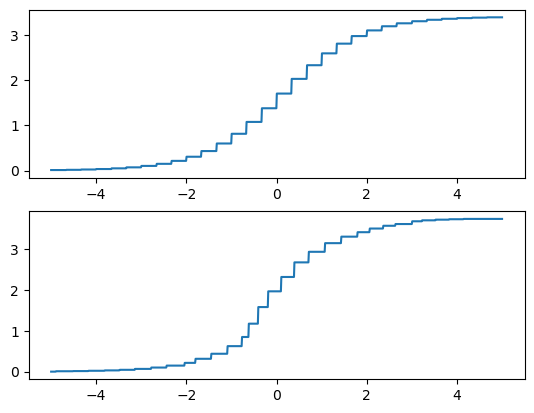

In [274]:
fig, ax = plt.subplots(2,1)
plot_step_function(beta0, ax[0])
plot_step_function(res.x, ax[1])

In [275]:
# sign-function initialization
n = 30
x = np.linspace(-5, 5, n + 1)
y = 1.7 * np.tanh(0.58 * x) + 1.7
y = np.concatenate([[0], y])
y[-1] = 3.4

a = np.ones(n + 1) * (10 / n)
a[0] = -5
b = np.zeros(n + 1)
b[n//2] = 1
beta0 = np.concatenate([a, b])
bounds = (
    [(None, None)] + [(0, None) for _ in range(1, n + 1)] + [(0, None) for _ in range(0, n + 1)]
)
c_for_step_function(beta0)
# check for one evaluation

0.86572265625

In [276]:
res = spo.minimize(c_for_step_function, beta0, method="Nelder-Mead", bounds=bounds)

In [277]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.8080078124999999
             x: [-3.879e+00  3.365e-01 ...  1.762e-05  2.927e-05]
           nit: 1123
          nfev: 1935
 final_simplex: (array([[-3.879e+00,  3.365e-01, ...,  1.762e-05,
                         2.927e-05],
                       [-3.879e+00,  3.365e-01, ...,  1.763e-05,
                         2.927e-05],
                       ...,
                       [-3.879e+00,  3.365e-01, ...,  1.763e-05,
                         2.927e-05],
                       [-3.879e+00,  3.365e-01, ...,  1.763e-05,
                         2.927e-05]]), array([ 8.080e-01,  8.080e-01, ...,  8.080e-01,  8.080e-01]))

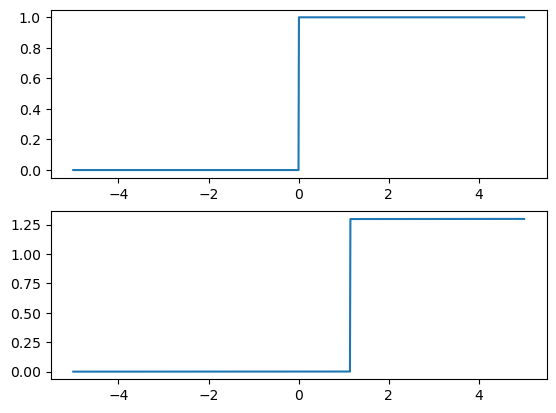

In [278]:
fig, ax = plt.subplots(2, 1)
plot_step_function(beta0, ax[0])
plot_step_function(res.x, ax[1])